<a href="https://colab.research.google.com/github/huggingface/deep-rl-class/blob/main/unit2/unit2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 2: Q-Learning with FrozenLake-v1 ⛄ and Taxi-v3 🚕

In this notebook, **you'll code from scratch your first Reinforcement Learning agent** playing FrozenLake ❄️ using Q-Learning, share it to the community, and experiment with different configurations

❓ If you have questions, please post them on #study-group-unit2 discord channel 👉 https://discord.gg/aYka4Yhff9

🎮 Environments: 
- [FrozenLake-v1](https://www.gymlibrary.ml/environments/toy_text/frozen_lake/)
- [Taxi-v3](https://www.gymlibrary.ml/environments/toy_text/taxi/)

📚 RL-Library: Python and Numpy

⬇️ Here is an example of what **you will achieve in just a couple of minutes.** ⬇️

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/envs.gif" alt="environments"/>

## Objectives of this notebook 🏆
At the end of the notebook, you will:
- Be able to use **Gym**, the environment library.
- Be able to code from scratch a Q-Learning agent.
- Be able to **push your trained agent and the code to the Hub** with a nice video replay and an evaluation score 🔥.




## This notebook is from Deep Reinforcement Learning Class

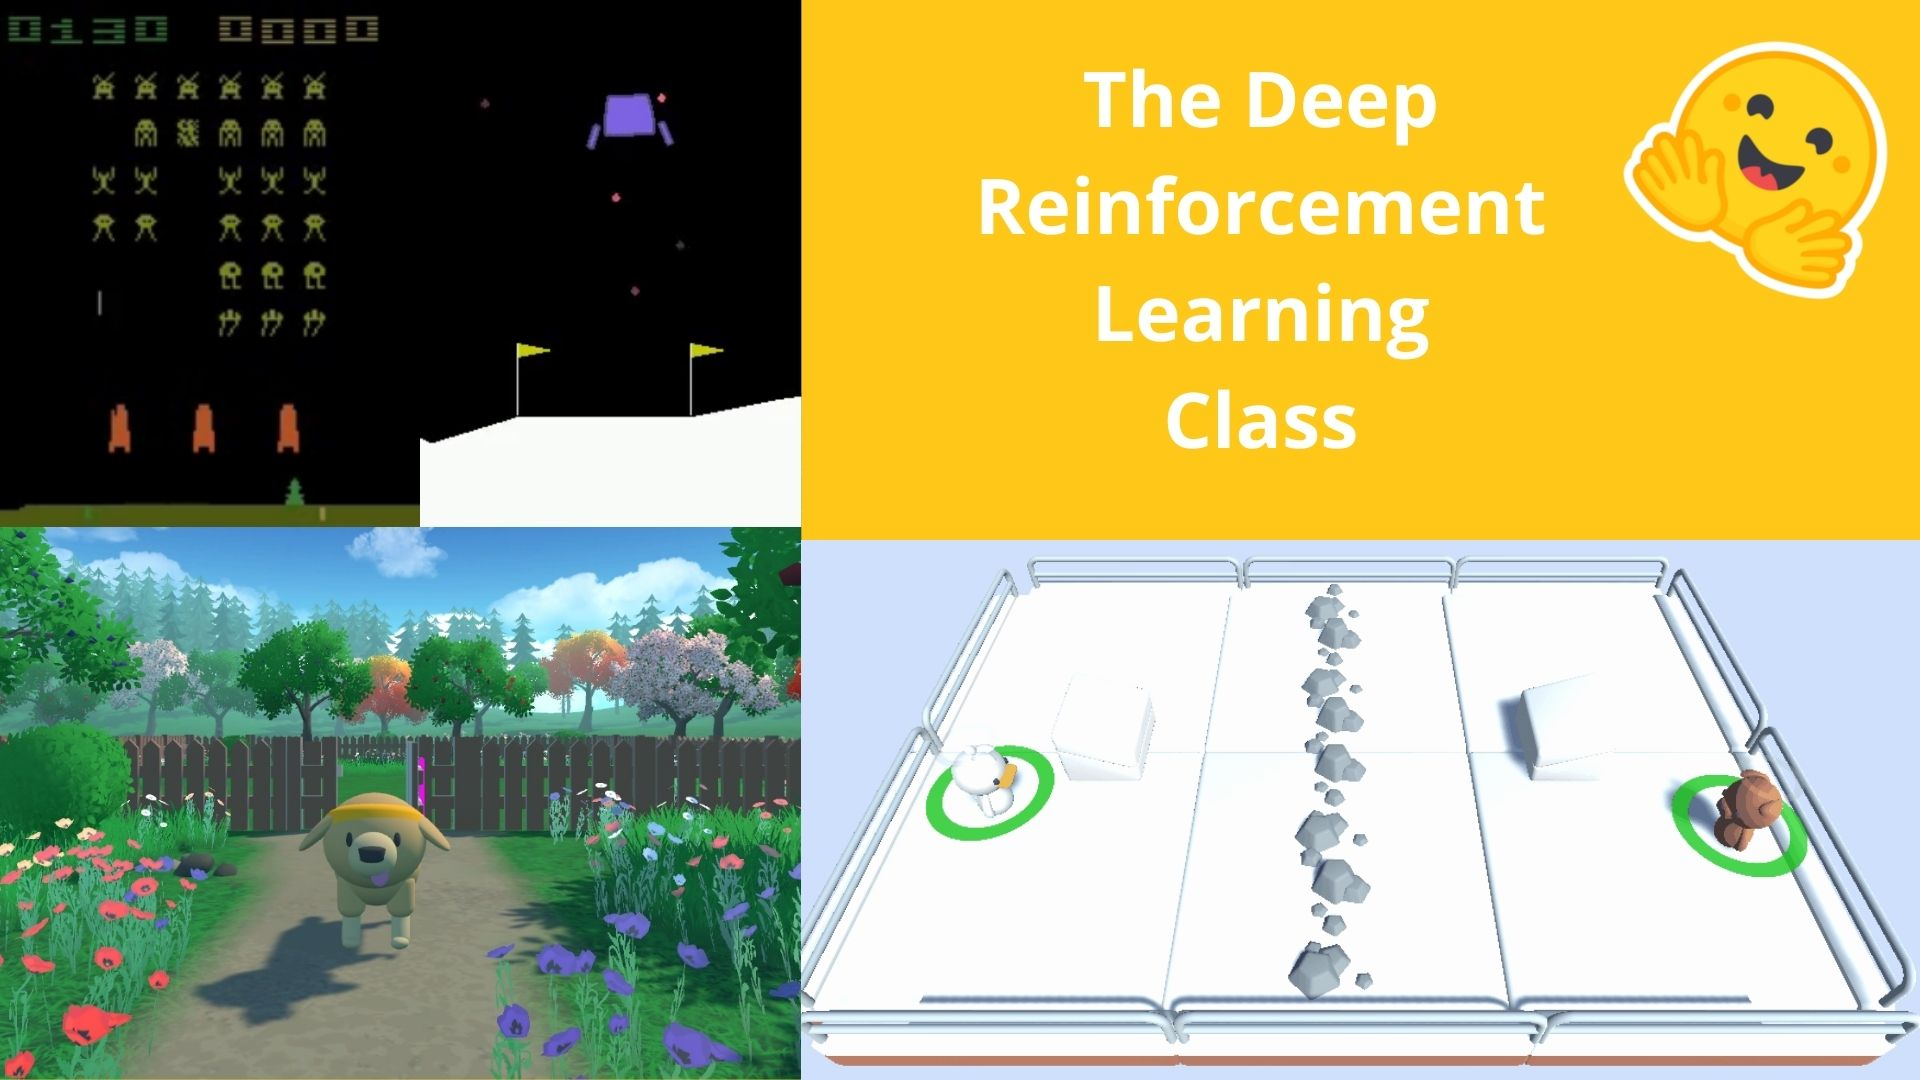

In this free course, you will:

- 📖 Study Deep Reinforcement Learning in **theory and practice**.
- 🧑‍💻 Learn to **use famous Deep RL libraries** such as Stable Baselines3, RL Baselines3 Zoo, and RLlib.
- 🤖 Train **agents in unique environments** 

And more check 📚 the syllabus 👉 https://github.com/huggingface/deep-rl-class

The best way to keep in touch is to join our discord server to exchange with the community and with us 👉🏻 https://discord.gg/aYka4Yhff9

## Prerequisites 🏗️
Before diving into the notebook, you need to:

🔲 📚 [Read the Unit 2 Readme](https://github.com/huggingface/deep-rl-class/blob/main/unit2/README.md) that contains all the information.

🔲 📚 [Read **An Introduction to Q-Learning Part 1**](https://huggingface.co/blog/deep-rl-q-part1) 

🔲 📚 [Read **An Introduction to Q-Learning Part 2**](https://huggingface.co/blog/deep-rl-q-part2) 

🔲 📢 Sign up to [our Discord Server](https://discord.gg/aYka4Yhff9) and **introduce yourself to #introduce-yourself channel 🥳**

🔲 🐕 Are you new to Discord? Check our **discord 101 to get the best practices** 👉 https://github.com/huggingface/deep-rl-class/blob/main/DISCORD.Md


## A small recap of Q-Learning

- The *Q-Learning* **is the RL algorithm that**  
  - Trains *Q-Function*, an **action-value function** that contains, as internal memory, a *Q-table* **that contains all the state-action pair values.**
    
  - Given a state and action, our Q-Function **will search into its Q-table the corresponding value.**
    

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-function-2.jpg" alt="Q function"/>

- When the training is done,**we have an optimal Q-Function, so an optimal Q-Table.**
    
- And if we **have an optimal Q-function**, we
have an optimal policy,since we **know for each state, what is the best action to take.**


<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/link-value-policy.jpg" alt="Link value policy"/>

But, in the beginning, our **Q-Table is useless since it gives arbitrary value for each state-action pair (most of the time we initialize the Q-Table to 0 values)**. But, as we’ll explore the environment and update our Q-Table it will give us better and better approximations

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-learning-1.jpg" alt="Link value policy"/>

This is the Q-Learning pseudocode:

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-learning-2.jpg" alt="Link value policy"/>


### Step 0: Setup a Virtual Display 💻

During the notebook, we'll need to generate a replay video. To do so, with colab, **we need to have a virtual screen to be able to render the environment** (and thus record the frames). 

Hence the following cell will install virtual screen libraries and create and run a virtual screen 🖥

In [ ]:
%%capture
!pip install pyglet==1.5.1 
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

### Step 1: Install dependencies 🔽
The first step is to install the dependencies, we’ll install multiple ones:

- `gym`: Contains the FrozenLake-v1 ⛄ and Taxi-v3 🚕 environments.
- `pygame`: Used for the FrozenLake-v1 and Taxi-v3 UI.
- `numPy`: Used for handling our Q-table.

The Hugging Face Hub 🤗 works as a central place where anyone can share and explore models and datasets. It has versioning, metrics, visualizations and other features that will allow you to easily collaborate with others.

You can see here all the Deep reinforcement Learning models available 👉 https://huggingface.co/models?other=q-learning



In [ ]:
%%capture
!pip install gym==0.24 # We install the newest gym version for the Taxi-v3 "rgb_array version"
!pip install pygame
!pip install numpy

!pip install huggingface_hub
!pip install pickle5
!pip install pyyaml==6.0 # avoid key error metadata
!pip install imageio imageio_ffmpeg

### Step 2: Import the packages 📦

In addition to the installed libraries, we also use:

- `random`: To generate random numbers (that will be useful for Epsilon-Greedy Policy).
- `imageio`: To generate a replay video






In [ ]:
import numpy as np
import gym
import random
import imageio
import os

import pickle5 as pickle
from tqdm.notebook import tqdm

We're now ready to code our Q-Learning algorithm 🔥

# Part 1: Frozen Lake ⛄ (non slippery version)

### Step 1: Create and understand [FrozenLake environment ⛄]((https://www.gymlibrary.ml/environments/toy_text/frozen_lake/)
---

💡 A good habit when you start to use an environment is to check its documentation 

👉 https://www.gymlibrary.ml/environments/toy_text/frozen_lake/

---

We're going to train our Q-Learning agent **to navigate from the starting state (S) to the goal state (G) by walking only on frozen tiles (F) and avoid holes (H)**.

We can have two sizes of environment:
- `map_name="4x4"`: a 4x4 grid version
- `map_name="8x8"`: a 8x8 grid version


The environment has two modes:
- `is_slippery=False`: The agent always move in the intended direction due to the non-slippery nature of the frozen lake.
- `is_slippery=True`: The agent may not always move in the intended direction due to the slippery nature of the frozen lake (stochastic).

For now let's keep it simple with the 4x4 map and non-slippery

In [ ]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version
env = gym.make() # TODO use the correct parameters

### Solution

In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)

You can create your own custom grid like this:

```python
desc=["SFFF", "FHFH", "FFFH", "HFFG"]
gym.make('FrozenLake-v1', desc=desc, is_slippery=True)
```

but we'll use the default environment for now.

### Let's see what the Environment looks like:


In [ ]:
# We create our environment with gym.make("<name_of_the_environment>")
env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

We see with `Observation Space Shape Discrete(16)` that the observation is a value representing the **agent’s current position as current_row * nrows + current_col (where both the row and col start at 0)**. 

For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. **For example, the 4x4 map has 16 possible observations.**


For instance, this is what state = 0 looks like:


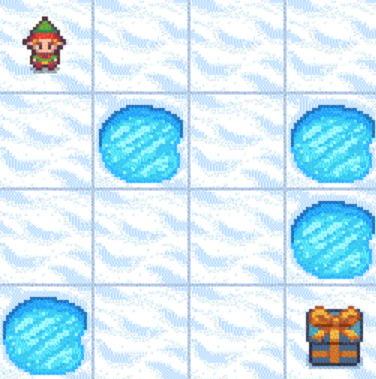

In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action

The action space (the set of possible actions the agent can take) is discrete with 4 actions available 🎮:
- 0: GO LEFT
- 1: GO DOWN
- 2: GO RIGHT
- 3: GO UP

Reward function 💰:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

### Step 2: Create and Initialize the Q-table 🗄️
(👀 Step 1 of the pseudocode)

<img src="https://huggingface.co/blog/assets/70_deep_rl_q_part1/Q-learning-2.jpg" alt="Q-Learning table"/>

It's time to initialize our Q-table! To know how many rows (states) and columns (actions) to use, we need to know the action and observation space. OpenAI Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`


In [ ]:
state_space = 
print("There are ", state_space, " possible states")

action_space = 
print("There are ", action_space, " possible actions")

In [ ]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = 
  return Qtable

In [ ]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

### Solution

In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

In [ ]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [ ]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

### Step 3: Define the epsilon-greedy policy 🤖

Epsilon-Greedy is the training policy that handles the exploration/exploitation trade-off.

The idea with Epsilon Greedy:

- With *probability 1 - ɛ* : **we do exploitation** (aka our agent selects the action with the highest state-action pair value).

- With *probability ɛ*: we do **exploration** (trying random action).

And as the training goes, we progressively **reduce the epsilon value since we will need less and less exploration and more exploitation.**

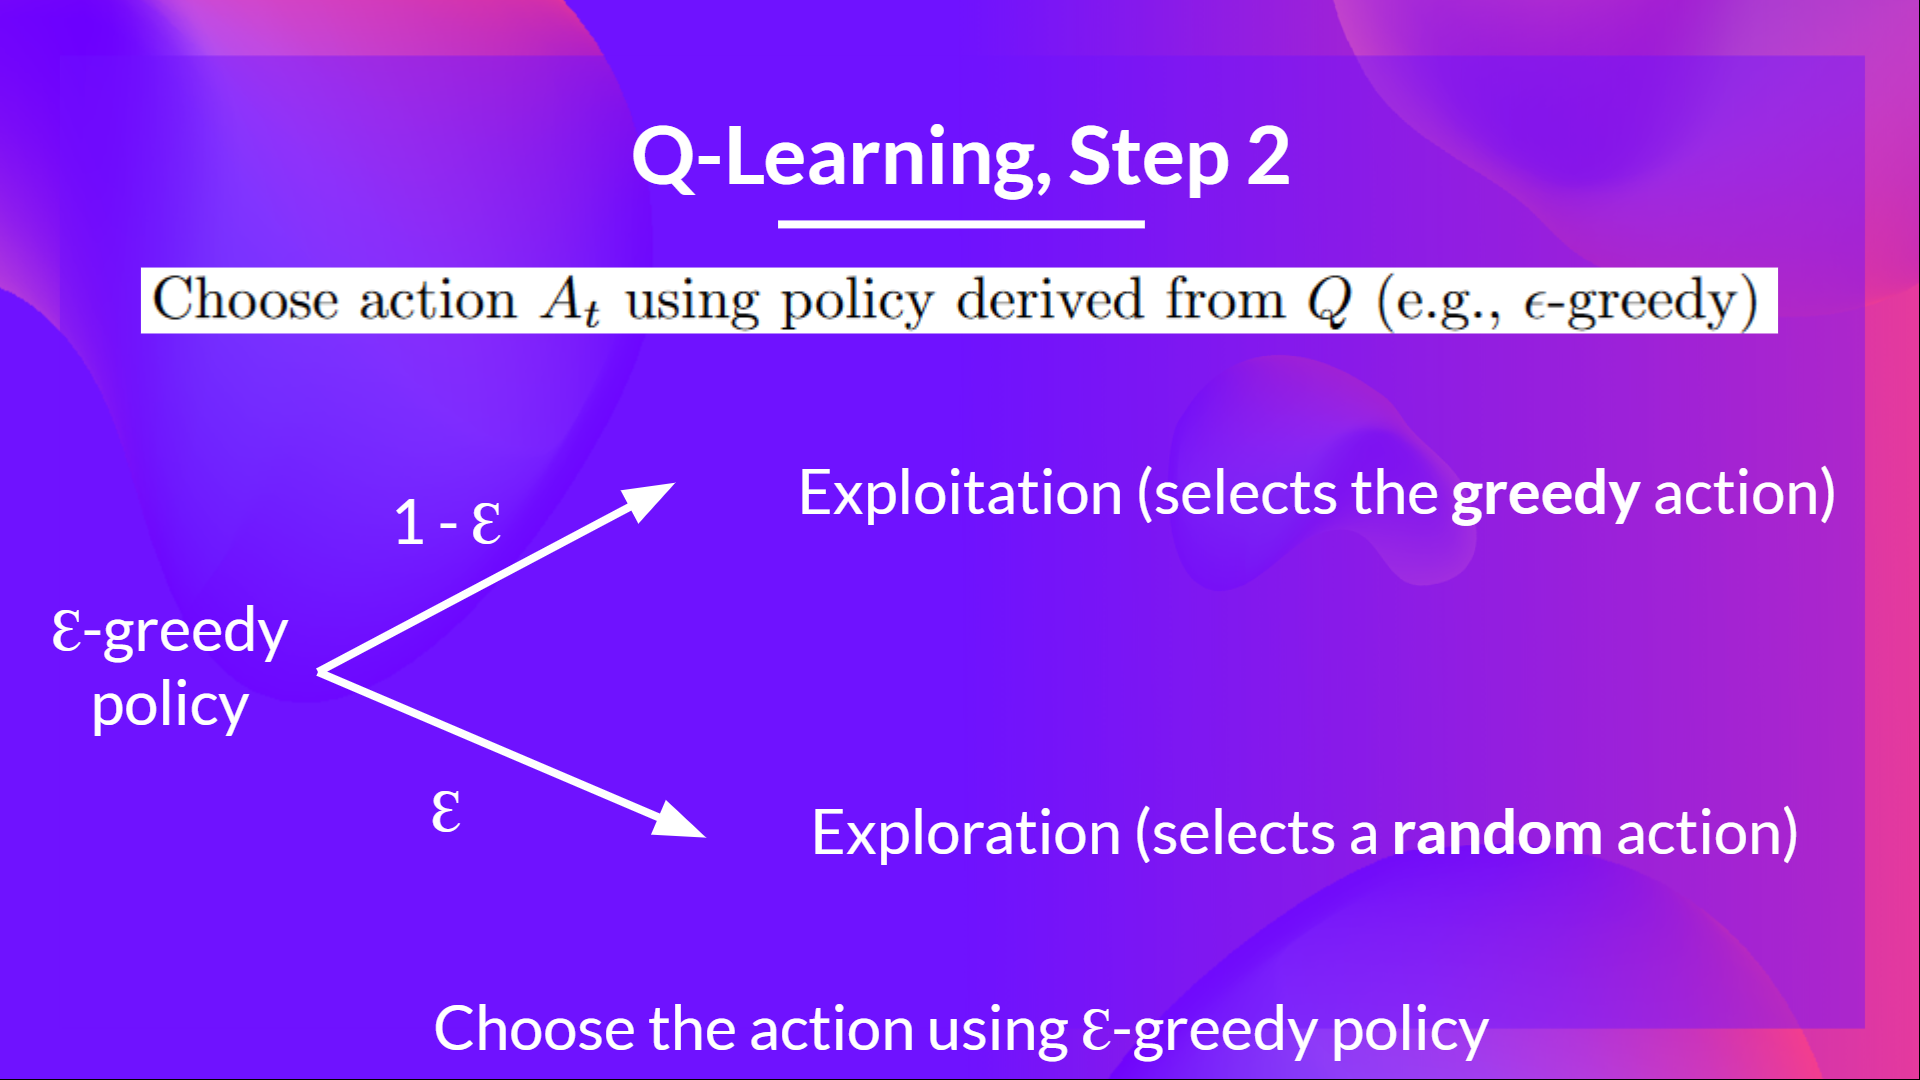

Thanks to Sambit for finding a bug on the epsilon function 🤗

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = 
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = 
  # else --> exploration
  else:
    action = # Take a random action
  
  return action

#### Solution

In [ ]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_int = random.uniform(0,1)
  # if random_int > greater than epsilon --> exploitation
  if random_int > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = np.argmax(Qtable[state])
  # else --> exploration
  else:
    action = env.action_space.sample()
  
  return action

### Step 4: Define the greedy policy 🤖
Remember we have two policies since Q-Learning is an **off-policy** algorithm. This means we're using a **different policy for acting and updating the value function**.

- Epsilon greedy policy (acting policy)
- Greedy policy (updating policy)

Greedy policy will also be the final policy we'll have when the Q-learning agent will be trained. The greedy policy is used to select an action from the Q-table.

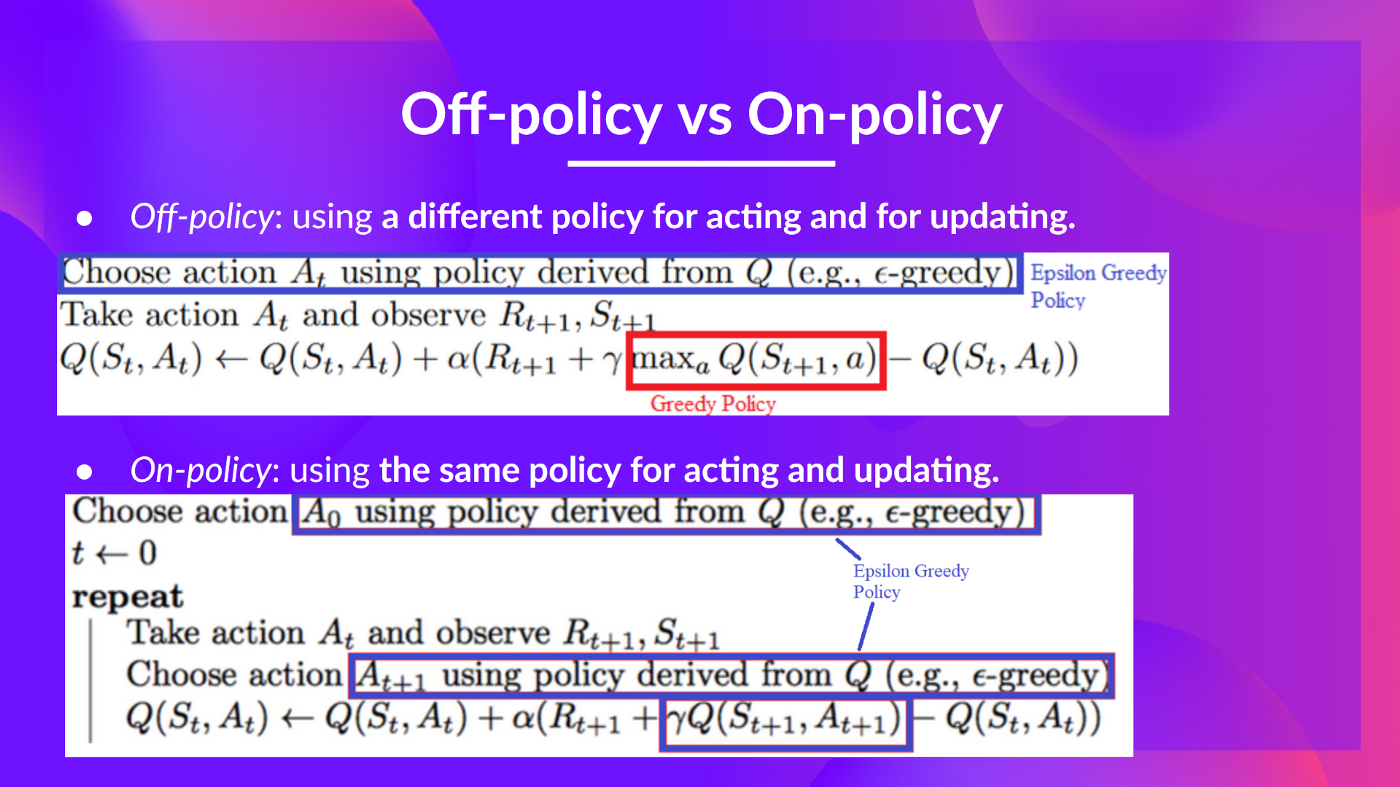

In [ ]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = 
  
  return action

#### Solution

In [ ]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])
  
  return action

### Step 5: Define the hyperparameters ⚙️
The exploration related hyperparamters are some of the most important ones. 

- We need to make sure that our agent **explores enough the state space** in order to learn a good value approximation, in order to do that we need to have progressive decay of the epsilon.
- If you decrease too fast epsilon (too high decay_rate), **you take the risk that your agent is stuck**, since your agent didn't explore enough the state space and hence can't solve the problem.

In [ ]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability 
decay_rate = 0.0005            # Exponential decay rate for exploration prob

### Step 6: Create the training loop method

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in range(n_training_episodes):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = 

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = 

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = 

      # If done, finish the episode
      if done:
        break
      
      # Our state is the new state
      state = new_state
  return Qtable

#### Solution

In [ ]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])   

      # If done, finish the episode
      if done:
        break
      
      # Our state is the new state
      state = new_state
  return Qtable

### Step 7: Train the Q-Learning agent 🏃

In [ ]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

### Step 8: Let's see what our Q-Learning table looks like now 👀

In [ ]:
Qtable_frozenlake

### Step 9: Define the evaluation method 📝

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0
    
    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward
        
      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

### Step 10: Evaluate our Q-Learning agent 📈
- Normally you should have mean reward of 1.0
- It's relatively easy since the state space is really small (16). What you can try to do is [to replace with the slippery version](https://www.gymlibrary.ml/environments/toy_text/frozen_lake/).

In [ ]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

### Step 11: Publish our trained model on the Hub 🔥
Now that we saw we got good results after the training, we can publish our trained model on the hub 🤗 with one line of code.

Here's an example of a Model Card:

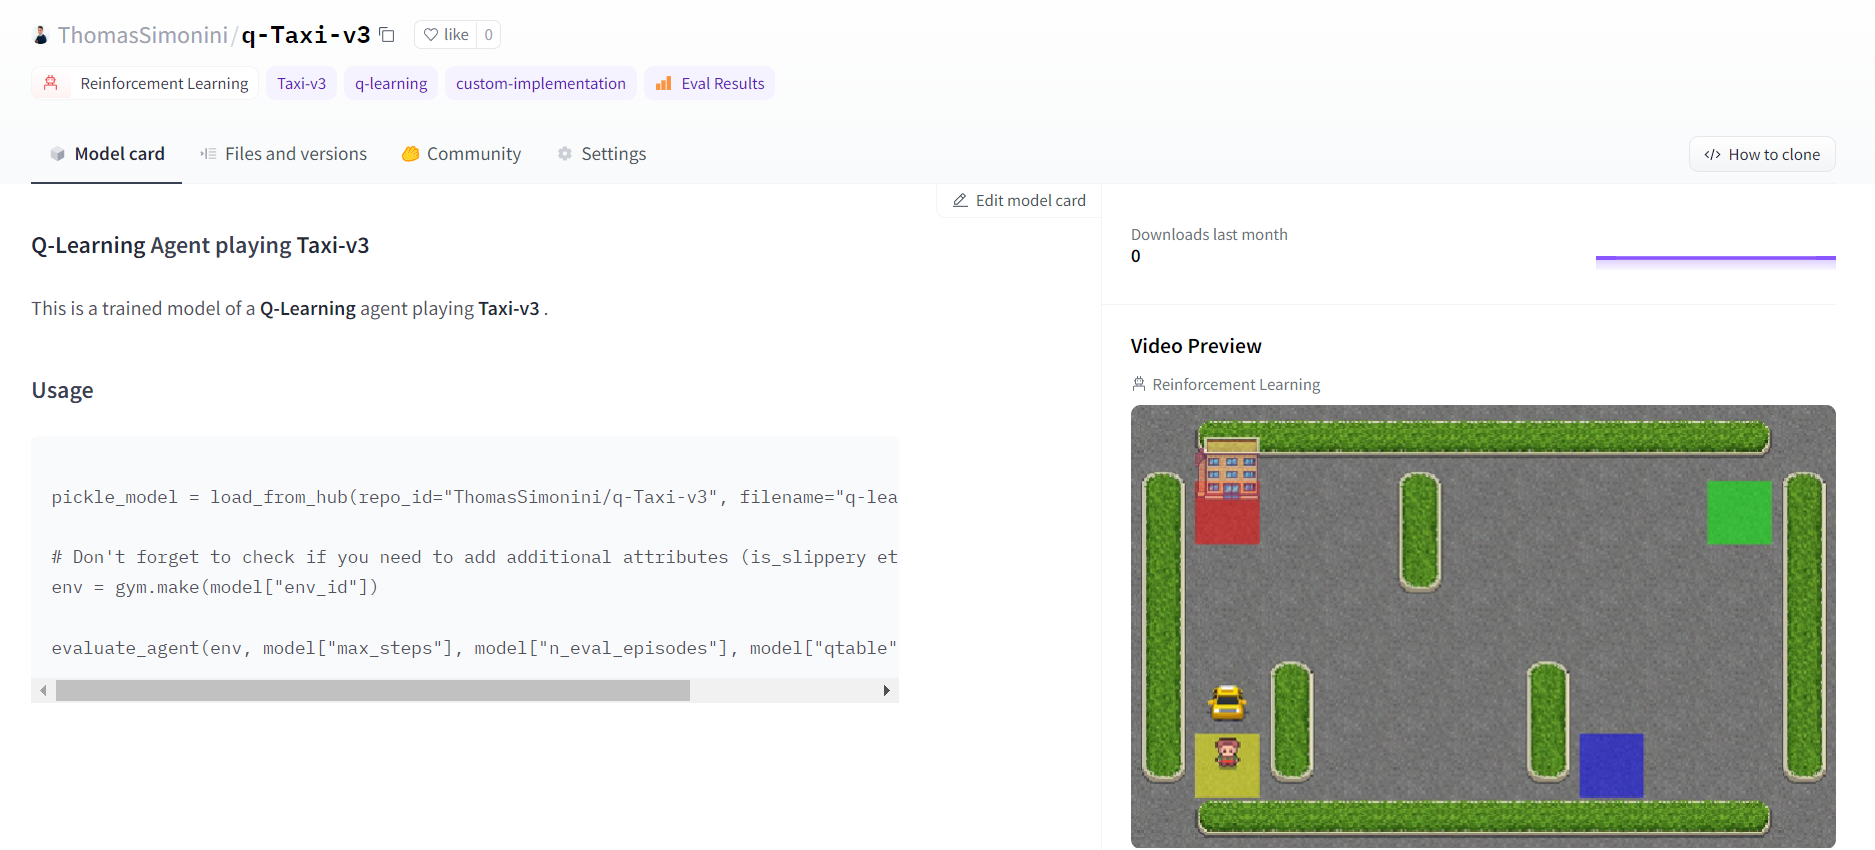

Under the hood, the Hub uses git-based repositories (don't worry if you don't know what git is), which means you can update the model with new versions as you experiment and improve your agent.

#### Do not modify this code

In [ ]:
%%capture
from huggingface_hub import HfApi, HfFolder, Repository
from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import json

In [ ]:
def record_video(env, Qtable, out_directory, fps=1):
  images = []  
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [ ]:
def push_to_hub(repo_id, 
                model,
                env,
                video_fps=1,
                local_repo_path="hub",
                commit_message="Push Q-Learning agent to Hub",
                token= None
                ):
  _, repo_name = repo_id.split("/")

  eval_env = env
  
  # Step 1: Clone or create the repo
  # Create the repo (or clone its content if it's nonempty)
  api = HfApi()
  
  repo_url = api.create_repo(
        repo_id=repo_id,
        token=token,
        private=False,
        exist_ok=True,)
  
  # Git pull
  repo_local_path = Path(local_repo_path) / repo_name
  repo = Repository(repo_local_path, clone_from=repo_url, use_auth_token=True)
  repo.git_pull()
  
  repo.lfs_track(["*.mp4"])

  # Step 1: Save the model
  if env.spec.kwargs.get("map_name"):
    model["map_name"] = env.spec.kwargs.get("map_name")
    if env.spec.kwargs.get("is_slippery", "") == False:
      model["slippery"] = False

  print(model)
  
    
  # Pickle the model
  with open(Path(repo_local_path)/'q-learning.pkl', 'wb') as f:
    pickle.dump(model, f)
  
  # Step 2: Evaluate the model and build JSON
  mean_reward, std_reward = evaluate_agent(eval_env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

  # First get datetime
  eval_datetime = datetime.datetime.now()
  eval_form_datetime = eval_datetime.isoformat()

  evaluate_data = {
        "env_id": model["env_id"], 
        "mean_reward": mean_reward,
        "n_eval_episodes": model["n_eval_episodes"],
        "eval_datetime": eval_form_datetime,
  }
  # Write a JSON file
  with open(Path(repo_local_path) / "results.json", "w") as outfile:
      json.dump(evaluate_data, outfile)

  # Step 3: Create the model card
  # Env id
  env_name = model["env_id"]
  if env.spec.kwargs.get("map_name"):
    env_name += "-" + env.spec.kwargs.get("map_name")

  if env.spec.kwargs.get("is_slippery", "") == False:
    env_name += "-" + "no_slippery"

  metadata = {}
  metadata["tags"] = [
        env_name,
        "q-learning",
        "reinforcement-learning",
        "custom-implementation"
    ]

  # Add metrics
  eval = metadata_eval_result(
      model_pretty_name=repo_name,
      task_pretty_name="reinforcement-learning",
      task_id="reinforcement-learning",
      metrics_pretty_name="mean_reward",
      metrics_id="mean_reward",
      metrics_value=f"{mean_reward:.2f} +/- {std_reward:.2f}",
      dataset_pretty_name=env_name,
      dataset_id=env_name,
    )

  # Merges both dictionaries
  metadata = {**metadata, **eval}

  model_card = f"""
  # **Q-Learning** Agent playing **{env_id}**
  This is a trained model of a **Q-Learning** agent playing **{env_id}** .
  """

  model_card += """
  ## Usage
  ```python
  """

  model_card += f"""model = load_from_hub(repo_id="{repo_id}", filename="q-learning.pkl")

  # Don't forget to check if you need to add additional attributes (is_slippery=False etc)
  env = gym.make(model["env_id"])

  evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])
  """

  model_card +="""
  ```
  """

  readme_path = repo_local_path / "README.md"
  readme = ""
  if readme_path.exists():
      with readme_path.open("r", encoding="utf8") as f:
        readme = f.read()
  else:
    readme = model_card

  with readme_path.open("w", encoding="utf-8") as f:
    f.write(readme)

  # Save our metrics to Readme metadata
  metadata_save(readme_path, metadata)

  # Step 4: Record a video
  video_path =  repo_local_path / "replay.mp4"
  record_video(env, model["qtable"], video_path, video_fps)
  
  # Push everything to hub
  print(f"Pushing repo {repo_name} to the Hugging Face Hub")
  repo.push_to_hub(commit_message=commit_message)

  print(f"Your model is pushed to the hub. You can view your model here: {repo_url}")

### .
By using `package_to_hub` **you evaluate, record a replay, generate a model card of your agent and push it to the hub**.

This way:
- You can **showcase our work** 🔥
- You can **visualize your agent playing** 👀
- You can **share with the community an agent that others can use** 💾
- You can **access a leaderboard 🏆 to see how well your agent is performing compared to your classmates** 👉 https://huggingface.co/spaces/chrisjay/Deep-Reinforcement-Learning-Leaderboard

To be able to share your model with the community there are three more steps to follow:

1️⃣ (If it's not already done) create an account to HF ➡ https://huggingface.co/join

2️⃣ Sign in and then, you need to store your authentication token from the Hugging Face website.
- Create a new token (https://huggingface.co/settings/tokens) **with write role**

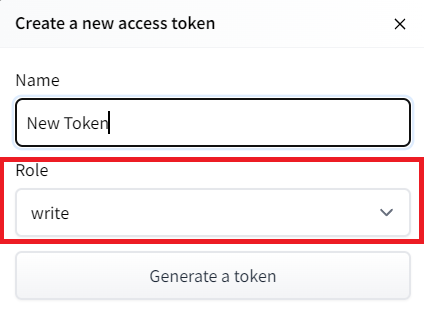

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

If you don't want to use a Google Colab or a Jupyter Notebook, you need to use this command instead: `huggingface-cli login`

3️⃣ We're now ready to push our trained agent to the 🤗 Hub 🔥 using `package_to_hub()` function

- Let's create **the model dictionary that contains the hyperparameters and the Q_table**.

In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_frozenlake
}

Let's fill the `package_to_hub` function:
- `repo_id`: the name of the Hugging Face Hub Repository that will be created/updated `
(repo_id = {username}/{repo_name})`
💡 **A good name is {username}/q-{env_id}**
- `model`: our model dictionary containing the hyperparameters and the Qtable.
- `env`: the environment.
- `commit_message`: message of the commit

In [ ]:
model

In [ ]:
username = "" # FILL THIS
repo_name = "q-FrozenLake-v1-4x4-noSlippery"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

Congrats 🥳 you've just implemented from scratch, trained and uploaded your first Reinforcement Learning agent. 
FrozenLake-v1 no_slippery is very simple environment, let's try an harder one 🔥.

# Part 2: Taxi-v3 🚖

### Step 1: Create and understand [Taxi-v3 🚕](https://www.gymlibrary.ml/environments/toy_text/taxi/)
---

💡 A good habit when you start to use an environment is to check its documentation 

👉 https://www.gymlibrary.ml/environments/toy_text/taxi/

---

In Taxi-v3 🚕, there are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.

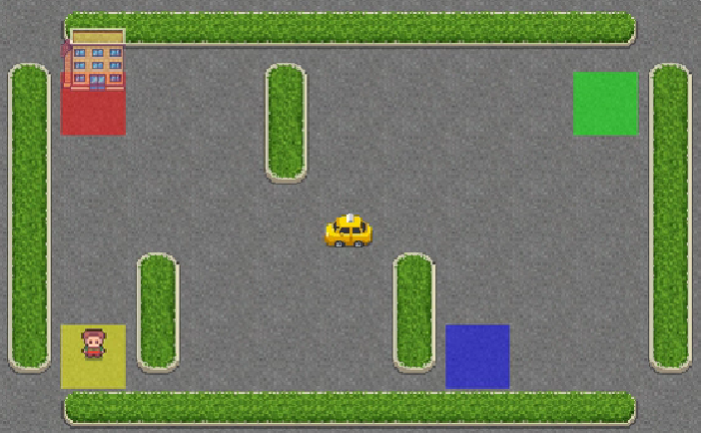

In [ ]:
env = gym.make("Taxi-v3")

There are **500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger** (including the case when the passenger is in the taxi), and **4 destination locations.**


In [ ]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

In [ ]:
action_space = env.action_space.n
print("There are ", action_space, " possible actions")

The action space (the set of possible actions the agent can take) is discrete with **6 actions available 🎮**:
- 0: move south
- 1: move north
- 2: move east
- 3: move west
- 4: pickup passenger
- 5: drop off passenger

Reward function 💰:
- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

In [ ]:
# Create our Q table with state_size rows and action_size columns (500x6)
Qtable_taxi = initialize_q_table(state_space, action_space)
print(Qtable_taxi)
print("Q-table shape: ", Qtable_taxi .shape)

### Step 2: Define the hyperparameters ⚙️
⚠ DO NOT MODIFY EVAL_SEED: the eval_seed array **allows us to evaluate your agent with the same taxi starting positions for every classmate**

In [ ]:
# Training parameters
n_training_episodes = 25000   # Total training episodes
learning_rate = 0.7           # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# DO NOT MODIFY EVAL_SEED
eval_seed = [16,54,165,177,191,191,120,80,149,178,48,38,6,125,174,73,50,172,100,148,146,6,25,40,68,148,49,167,9,97,164,176,61,7,54,55,
 161,131,184,51,170,12,120,113,95,126,51,98,36,135,54,82,45,95,89,59,95,124,9,113,58,85,51,134,121,169,105,21,30,11,50,65,12,43,82,145,152,97,106,55,31,85,38,
 112,102,168,123,97,21,83,158,26,80,63,5,81,32,11,28,148] # Evaluation seed, this ensures that all classmates agents are trained on the same taxi starting position
                                                          # Each seed has a specific starting state

# Environment parameters
env_id = "Taxi-v3"           # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05           # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob


### Step 3: Train our Q-Learning agent 🏃

In [ ]:
Qtable_taxi = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_taxi)

In [ ]:
Qtable_taxi

### Step 4: Create a model dictionary 💾 and publish our trained model on the Hub 🔥



In [ ]:
model = {
    "env_id": env_id,
    "max_steps": max_steps,
    "n_training_episodes": n_training_episodes,
    "n_eval_episodes": n_eval_episodes,
    "eval_seed": eval_seed,

    "learning_rate": learning_rate,
    "gamma": gamma,

    "max_epsilon": max_epsilon,
    "min_epsilon": min_epsilon,
    "decay_rate": decay_rate,

    "qtable": Qtable_taxi
}

In [ ]:
username = "" # FILL THIS
repo_name = "q-Taxi-v3"
push_to_hub(
    repo_id=f"{username}/{repo_name}",
    model=model,
    env=env)

Compare the results of your Taxi-v3 with your classmates using the leaderboard 🏆 👉 https://huggingface.co/spaces/chrisjay/Deep-Reinforcement-Learning-Leaderboard

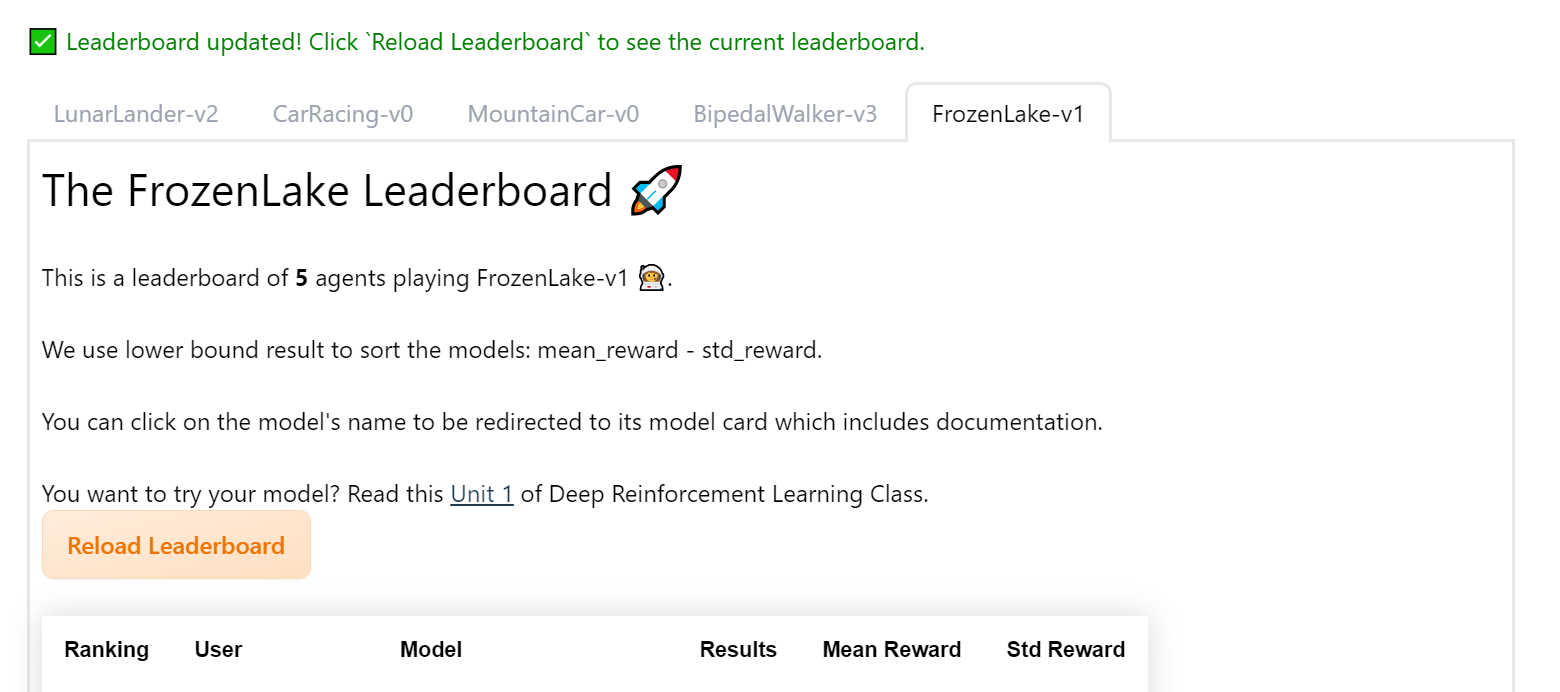

# Part 3: Load from Hub 🔽

What's amazing with Hugging Face Hub 🤗 is that you can easily load powerful models from the community.

Loading a saved model from the Hub is really easy.
1. You go https://huggingface.co/models?other=q-learning to see the list of all the q-learning saved models.
2. You select one and copy its repo_id

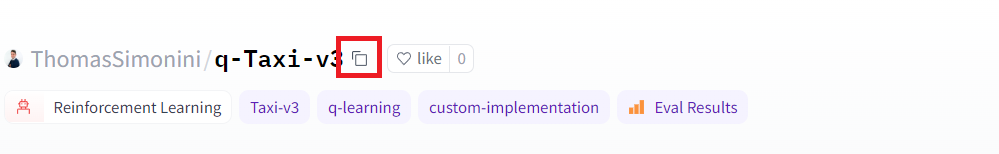

3. Then we just need to use `load_from_hub` with:
- The repo_id
- The filename: the saved model inside the repo.

#### Do not modify this code

In [ ]:
from urllib.error import HTTPError

from huggingface_hub import hf_hub_download


def load_from_hub(repo_id: str, filename: str) -> str:
    """
    Download a model from Hugging Face Hub.
    :param repo_id: id of the model repository from the Hugging Face Hub
    :param filename: name of the model zip file from the repository
    """
    try:
        from huggingface_hub import cached_download, hf_hub_url
    except ImportError:
        raise ImportError(
            "You need to install huggingface_hub to use `load_from_hub`. "
            "See https://pypi.org/project/huggingface-hub/ for installation."
        )

    # Get the model from the Hub, download and cache the model on your local disk
    pickle_model = hf_hub_download(
        repo_id=repo_id,
        filename=filename
    )

    with open(pickle_model, 'rb') as f:
      downloaded_model_file = pickle.load(f)
    
    return downloaded_model_file

### .

In [ ]:
model = load_from_hub(repo_id="ThomasSimonini/q-Taxi-v3", filename="q-learning.pkl")

print(model)
env = gym.make(model["env_id"])

evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

In [ ]:
model = load_from_hub(repo_id="ThomasSimonini/q-FrozenLake-v1-no-slippery", filename="q-learning.pkl")

env = gym.make(model["env_id"], is_slippery=False)

evaluate_agent(env, model["max_steps"], model["n_eval_episodes"], model["qtable"], model["eval_seed"])

Congrats 🥳, you've just implemented, trained, and uploaded your first Reinforcement Learning agent.

Understanding Q-Learning is an **important step to understanding value-based methods.**

In the next Unit with Deep Q-Learning, we'll see that creating and updating a Q-table was a good strategy — **however, this is not scalable.**

For instance, imagine you create an agent that learns to play Doom. Doom is a large environment with a huge state space (millions of different states). Creating and updating a Q-table for that environment would not be efficient. That's why we'll study Deep Q-Learning, an algorithm **where we use a neural network that approximates, given a state, the different Q-values for each action.**

## Some additional challenges 🏆
The best way to learn **is to try things by your own**! As you saw, the current agent is not doing great. As a first suggestion, you can train for more steps. With 1,000,000 steps, we saw some great results! 

In the [Leaderboard](https://huggingface.co/spaces/chrisjay/Deep-Reinforcement-Learning-Leaderboard) you will find your agents. Can you get to the top?

Here are some ideas to achieve so:
* Train more steps
* Try different hyperparameters by looking at what your classmates have done.
* **Push your new trained model** on the Hub 🔥

Are walking on ice and driving taxis too boring to you? Try to **change the environment**, why not using FrozenLake-v1 slippery version? Check how they work [using the gym documentation](https://www.gymlibrary.ml/) and have fun 🎉.

________________________________________________________________________
Congrats on finishing this chapter! That was the biggest one, **and there was a lot of information.**

If you’re still feel confused with all these elements...it's totally normal! **This was the same for me and for all people who studied RL.**

Take time to really **grasp the material before continuing and try the additional challenges**. It’s important to master these elements and having a solid foundations.

Naturally, during the course, we’re going to use and deeper explain again these terms but **it’s better to have a good understanding of them now before diving into the next chapters.**


### This is a course built with you 👷🏿‍♀️

We want to improve and update the course iteratively with your feedback. If you have some, please fill this form 👉 https://forms.gle/3HgA7bEHwAmmLfwh9

If you found some issues in this notebook, please [open an issue on the Github Repo](https://github.com/huggingface/deep-rl-class/issues).

See you on [Unit 3](https://github.com/huggingface/deep-rl-class/tree/main/unit3#unit-3-deep-q-learning-with-atari-games-)! 🔥
## Keep learning, stay awesome 🤗